Parsed 377 NSL letters
Processing Issued NSL
Processing ROIs
Use degree 1 polyfit
Use degree 1 polyfit
Use degree 1 polyfit


/tmp/ipykernel_12037/3039465977.py:171: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


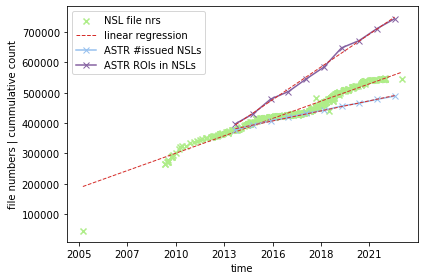

In [2]:
# This file plots NSL file numbers and compares them to ASTR data

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd

from nsl_class import NSL

# Optionally, truncate older (and very sparse) data
MIN_YEAR = None

# NSL data sources
NSL_CSV_FILE_PATHS = [
    "../../data/extracted/nsl_letters_google.csv",
    "../../data/extracted/nsl_letters_apple.csv",
    "../../data/extracted/nsl_letters_nslarchive.csv"
]

# Merge all CSVs into one pandas data frame
nsls_df = pd.concat(map(pd.read_csv, NSL_CSV_FILE_PATHS), ignore_index=True)

# Drop letters with unknown NSL number
nsls_df.dropna(subset=['file number'], inplace=True)
print(f"Parsed {len(nsls_df)} NSL letters")

# Extract issue date and nsl file number from data frame
public_available_nsls_x_axis_issue_date = []
public_available_nsls_y_axis_nsl_number = []
for nsl_index, nsl_row in nsls_df.iterrows():
    issue_date = NSL.parse_strftime(nsl_row['issue date'])
    # If we use a cutoff, and this letter is outside of the used range, discard
    if MIN_YEAR != None and issue_date.year < MIN_YEAR:
        continue

    public_available_nsls_x_axis_issue_date.append(issue_date)
    public_available_nsls_y_axis_nsl_number.append(NSL.file_str_to_numbers(nsl_row['file number']))

# Read ASTR data from CSV
ASTR_CSV_PATH = "../../data/extracted/fisa_astr_data.csv"
astr_df = pd.read_csv(ASTR_CSV_PATH)

# Create a dictionary with the year as key and the data column as values
astr_nsls_issued = dict(astr_df[["year", "ASTR issued NSLs"]].dropna().values)
astr_rois = dict(astr_df[["year", "ASTR ROIs"]].dropna().values)

# Make keys integer
astr_nsls_issued = {int(k): v for k, v in astr_nsls_issued.items()}
astr_rois = {int(k): v for k, v in astr_rois.items()}

def get_cumulative_data_over_years(data, base_number_of_nsls=0):
    """
    Expects `data` to have data per year.
    Computes the cumulative sum of entries in data: 
    data[0], data[0] + data[1], data[0] + data[1] + data[2], etc.
    """
    x_axis_time = []
    y_axis_total_nsls = []
    # start with base_number_of_nsls if not 0
    total_number_of_nsls = base_number_of_nsls
    for year, number in data.items():
        total_number_of_nsls += number
        x_axis_time.append(datetime(year=year, month=12, day=31))
        y_axis_total_nsls.append(total_number_of_nsls)
    return x_axis_time, y_axis_total_nsls

def find_smallest_relevant_file_nr(data=None, year=None):
    """
    Expects data to have years as keys.

    Find the smallest file number with a timestamp that is
    just before the oldest timestamp in data, or before year.
    """

    # Take the year of the oldest entry in data.
    if year == None:
        year = min(data.keys())
    
    cutoff = datetime(year=year, month=1, day=1)
    smallest_file_number_timestamp = None
    smallest_file_number = None
    # Go through all NSLs to find the oldest one above the cutoff date
    for i, nsl_issue_date in enumerate(public_available_nsls_x_axis_issue_date):
        # Update variable if older NSL above cutoff date was found
        if cutoff <= nsl_issue_date and (smallest_file_number_timestamp == None or nsl_issue_date <= smallest_file_number_timestamp):
            # In case two NSLs are issued on the same day, take the one with the smaller file number
            if smallest_file_number == None or public_available_nsls_y_axis_nsl_number[i] < smallest_file_number:
                smallest_file_number_timestamp = nsl_issue_date
                smallest_file_number = public_available_nsls_y_axis_nsl_number[i]

    return smallest_file_number

print("Processing Issued NSL")
astr_nsls_issued_y_axis_offset = find_smallest_relevant_file_nr(astr_nsls_issued)
astr_nsls_issued_x_axis_time, astr_nsls_issued_y_axis_cumulative_number = get_cumulative_data_over_years(astr_nsls_issued, astr_nsls_issued_y_axis_offset-next(iter(astr_nsls_issued)))

print("Processing ROIs")
astr_rois_y_axis_offset = find_smallest_relevant_file_nr(astr_rois)
astr_rois_in_nsls_x_axis_time, astr_rois_in_nsls_y_axis_cumulative_number = get_cumulative_data_over_years(astr_rois, astr_rois_y_axis_offset-next(iter(astr_rois)))


#
# Plotting
#
plt.rc("axes", axisbelow=True)

plt.rcParams["font.size"] = 20
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["figure.figsize"] = (14,8)

colors = ["#afed89", "#ffc1cc", "#ebc197", "#95c0ef", "#8561a1", 
            "#edc895", "#2c7707", "#9c9ed1", "#ccab0a"]

def to_ordinal(xs):
    return list(map(lambda x: x.toordinal(), xs))

def poly_regression(xs, ys, deg=1):
    """
    Compute regression on xs, ys with polynomial of degree `deg`
    (for deg=1, this computes the linear regression)
    """                                                                                                                                                                                                        
    print(f"Use degree {deg} polyfit")
    x_vals = np.array(xs)
    coeffs = np.polyfit(xs, np.array(ys), deg=deg)
    new_xs = np.linspace(xs[0], xs[-1], len(x_vals))
    new_ys = []
    for x in new_xs:
        y = 0
        for i, coeff in enumerate(coeffs):
            y += x**(deg-i) * coeff
        new_ys.append(y)

    return new_xs, new_ys

def plot_regression(ax, xs, ys, deg=1, label=None):
    """
    Add a line with the polynomial regression of degree `deg` to axis `ax`
    """
    regression_xs, regression_ys = poly_regression(xs, ys)                                                                                                                                                               
    ax1.plot(regression_xs, regression_ys, linestyle="--", color="#d52d2a", label=label, linewidth=1)

# sort file numbers
public_available_nsls_x_axis_issue_date_ordinal = to_ordinal(public_available_nsls_x_axis_issue_date)
sorted_public_available_nsls_plotting_data = sorted(zip(public_available_nsls_x_axis_issue_date_ordinal, public_available_nsls_y_axis_nsl_number), key=lambda x: x[0])
public_available_nsls_x_axis_issue_date_sorted, public_available_nsls_y_axis_nsl_number_sorted = map(list, list(zip(*sorted_public_available_nsls_plotting_data)))

# Plotting the numbers acquired from different sources
fig, ax1 = plt.subplots()

# nsl numbers from publicly available nsl files
plt.scatter(public_available_nsls_x_axis_issue_date_sorted, public_available_nsls_y_axis_nsl_number_sorted, color=colors[0], marker="x", label="NSL file nrs")
plot_regression(ax1, public_available_nsls_x_axis_issue_date_sorted, public_available_nsls_y_axis_nsl_number_sorted, label="linear regression")

# number reported in astar
plt.plot(to_ordinal(astr_nsls_issued_x_axis_time), astr_nsls_issued_y_axis_cumulative_number, colors[3], marker="x", label="ASTR #issued NSLs")
plot_regression(ax1, to_ordinal(astr_nsls_issued_x_axis_time), astr_nsls_issued_y_axis_cumulative_number)

# rois reported in astar
plt.plot(to_ordinal(astr_rois_in_nsls_x_axis_time), astr_rois_in_nsls_y_axis_cumulative_number, colors[4], marker="x", label="ASTR ROIs in NSLs")
plot_regression(ax1, to_ordinal(astr_rois_in_nsls_x_axis_time), astr_rois_in_nsls_y_axis_cumulative_number)


ax = plt.gca()
x_ticks = ax.get_xticks()

# set plot xticklabels
new_labels = [datetime.fromordinal(int(item)).year for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)

# Save
plt.xlabel("time")
plt.ylabel("file numbers | cummulative count")
plt.legend(loc="upper left")
plt.tight_layout()

OUTPUT_DATA_DIR = "../../data/processed/"
plt.savefig("{}/file_numbers.pdf".format(OUTPUT_DATA_DIR))
plt.savefig("{}/file_numbers.png".format(OUTPUT_DATA_DIR))